# Análisis y tratamiento de valores faltantes en dataset del titánic

Este notebook analiza el tratamiento de valores faltantes en el dataset del Titanic, implementando diferentes estrategias de imputación y validación

**Contenido**:
1. Análisis detallado de Missingness

2. Estrategias de imputación

3. Validación de imputaciones

## Importar librerías


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import missingno as msno

In [8]:
# Configuraciones de visualización
plt.style.use('fivethirtyeight')
sns.set_palette('Set2')
plt.rcParams['figure.figsize'] = (12, 6)

# Cargar datos
df = pd.read_csv('../data/Titanic-Dataset-Canvas.csv')

# Mostrar información inicial
print("Dimensiones del dataset:", df.shape)
print("\nInformación del dataset:")
print(df.info())

Dimensiones del dataset: (891, 12)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


## 1. Análisis Detallado de Missingness


### 1.1 Patrón de Missingness
Analizaremos si los valores faltantes siguen un patrón MCAR (Missing Completely at Random), MAR (Missing at Random) o MNAR (Missing Not at Random).

In [9]:
# Análisis de valores faltantes
print("1. Análisis de Valores Faltantes:")
missing_values = df.isnull().sum()
missing_percentages = (missing_values / len(df)) * 100
missing_info = pd.DataFrame({
    'Valores Faltantes': missing_values,
    'Porcentaje': missing_percentages
}).sort_values('Porcentaje', ascending=False)

print(missing_info[missing_info['Valores Faltantes'] > 0])

1. Análisis de Valores Faltantes:
          Valores Faltantes  Porcentaje
Cabin                   687   77.104377
Age                     177   19.865320
Embarked                  2    0.224467


### 1.1.2 Visualización de Patrones de Valores Faltantes
Utilizamos la librería `missingno` para visualizar los patrones de datos faltantes y detectar posibles correlaciones entre las ausencias.

C:\Users\rgarz\AppData\Local\Temp\ipykernel_14412\111619552.py:5: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1500x600 with 0 Axes>

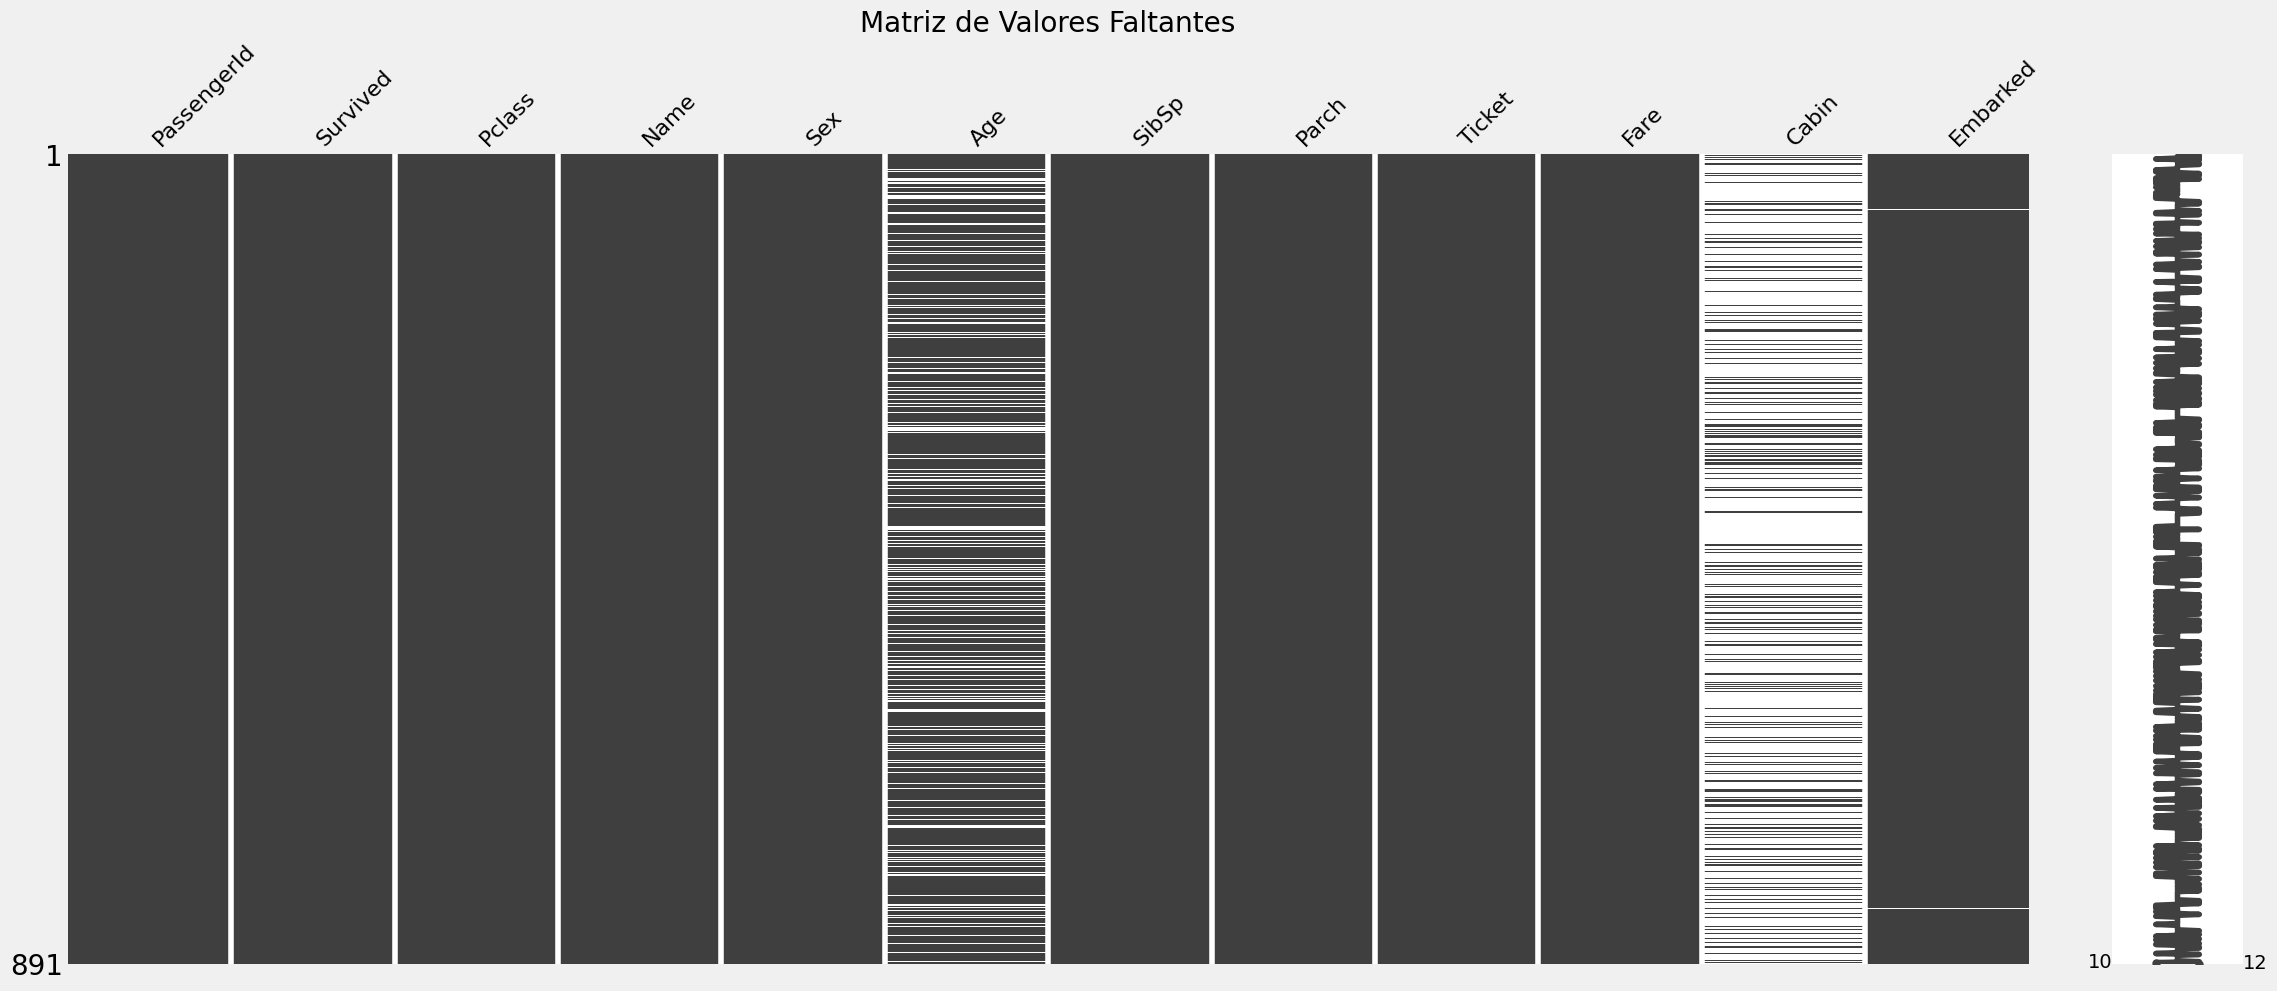

In [10]:
# Visualización de patrones de valores faltantes
plt.figure(figsize=(15, 6))
msno.matrix(df)
plt.title('Matriz de Valores Faltantes')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

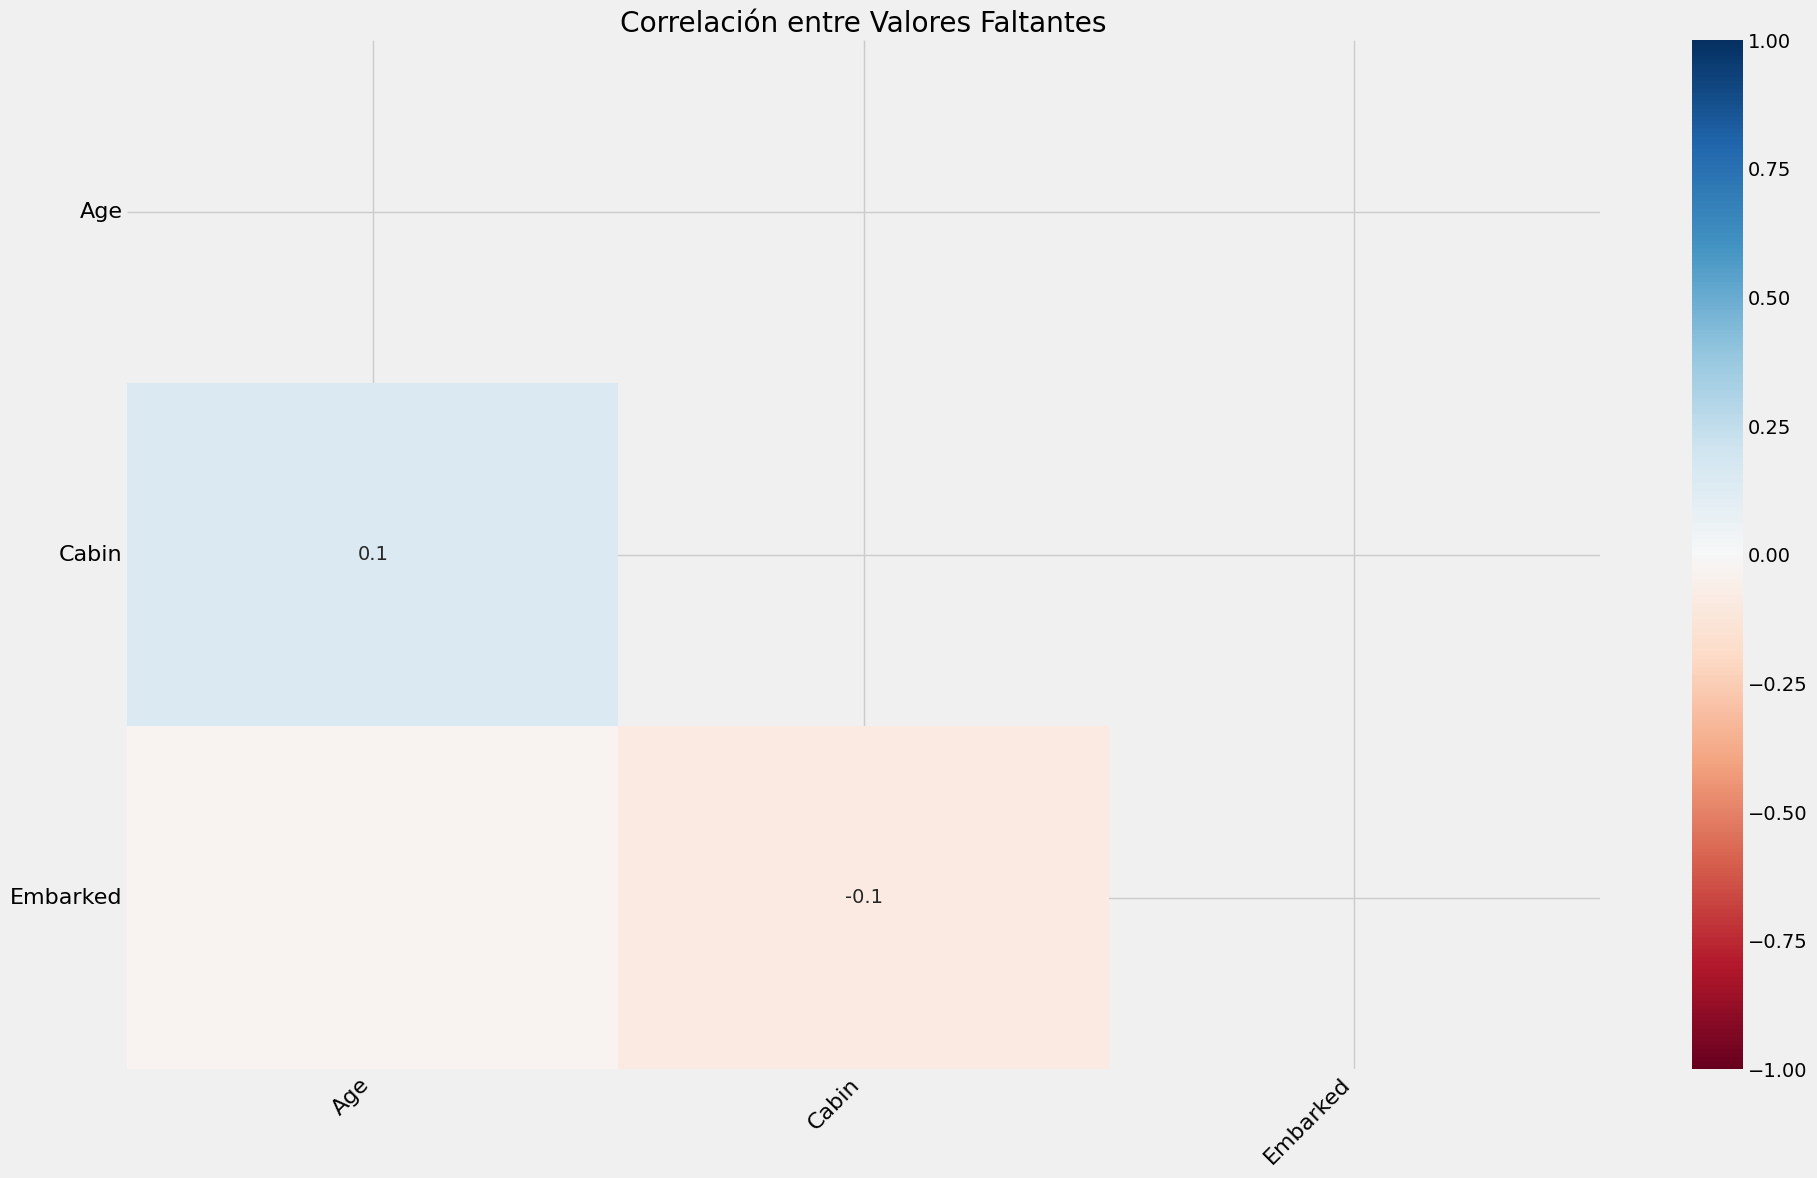

In [11]:
# Heatmap de correlación entre valores faltantes
plt.figure(figsize=(12, 8))
msno.heatmap(df)
plt.title('Correlación entre Valores Faltantes')
plt.tight_layout()
plt.show()

### 1.1.3 Análisis de Variables Numéricas
Examinamos las estadísticas descriptivas y distribuciones de las variables numéricas para entender mejor los datos.

In [12]:
# Análisis de variables numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("2. Estadísticas de Variables Numéricas:")
print(df[numeric_cols].describe())

2. Estadísticas de Variables Numéricas:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


### 1.1.4 Distribuciones de Variables Numéricas
Visualizamos la distribución de cada variable numérica para identificar patrones, sesgos y posibles outliers.

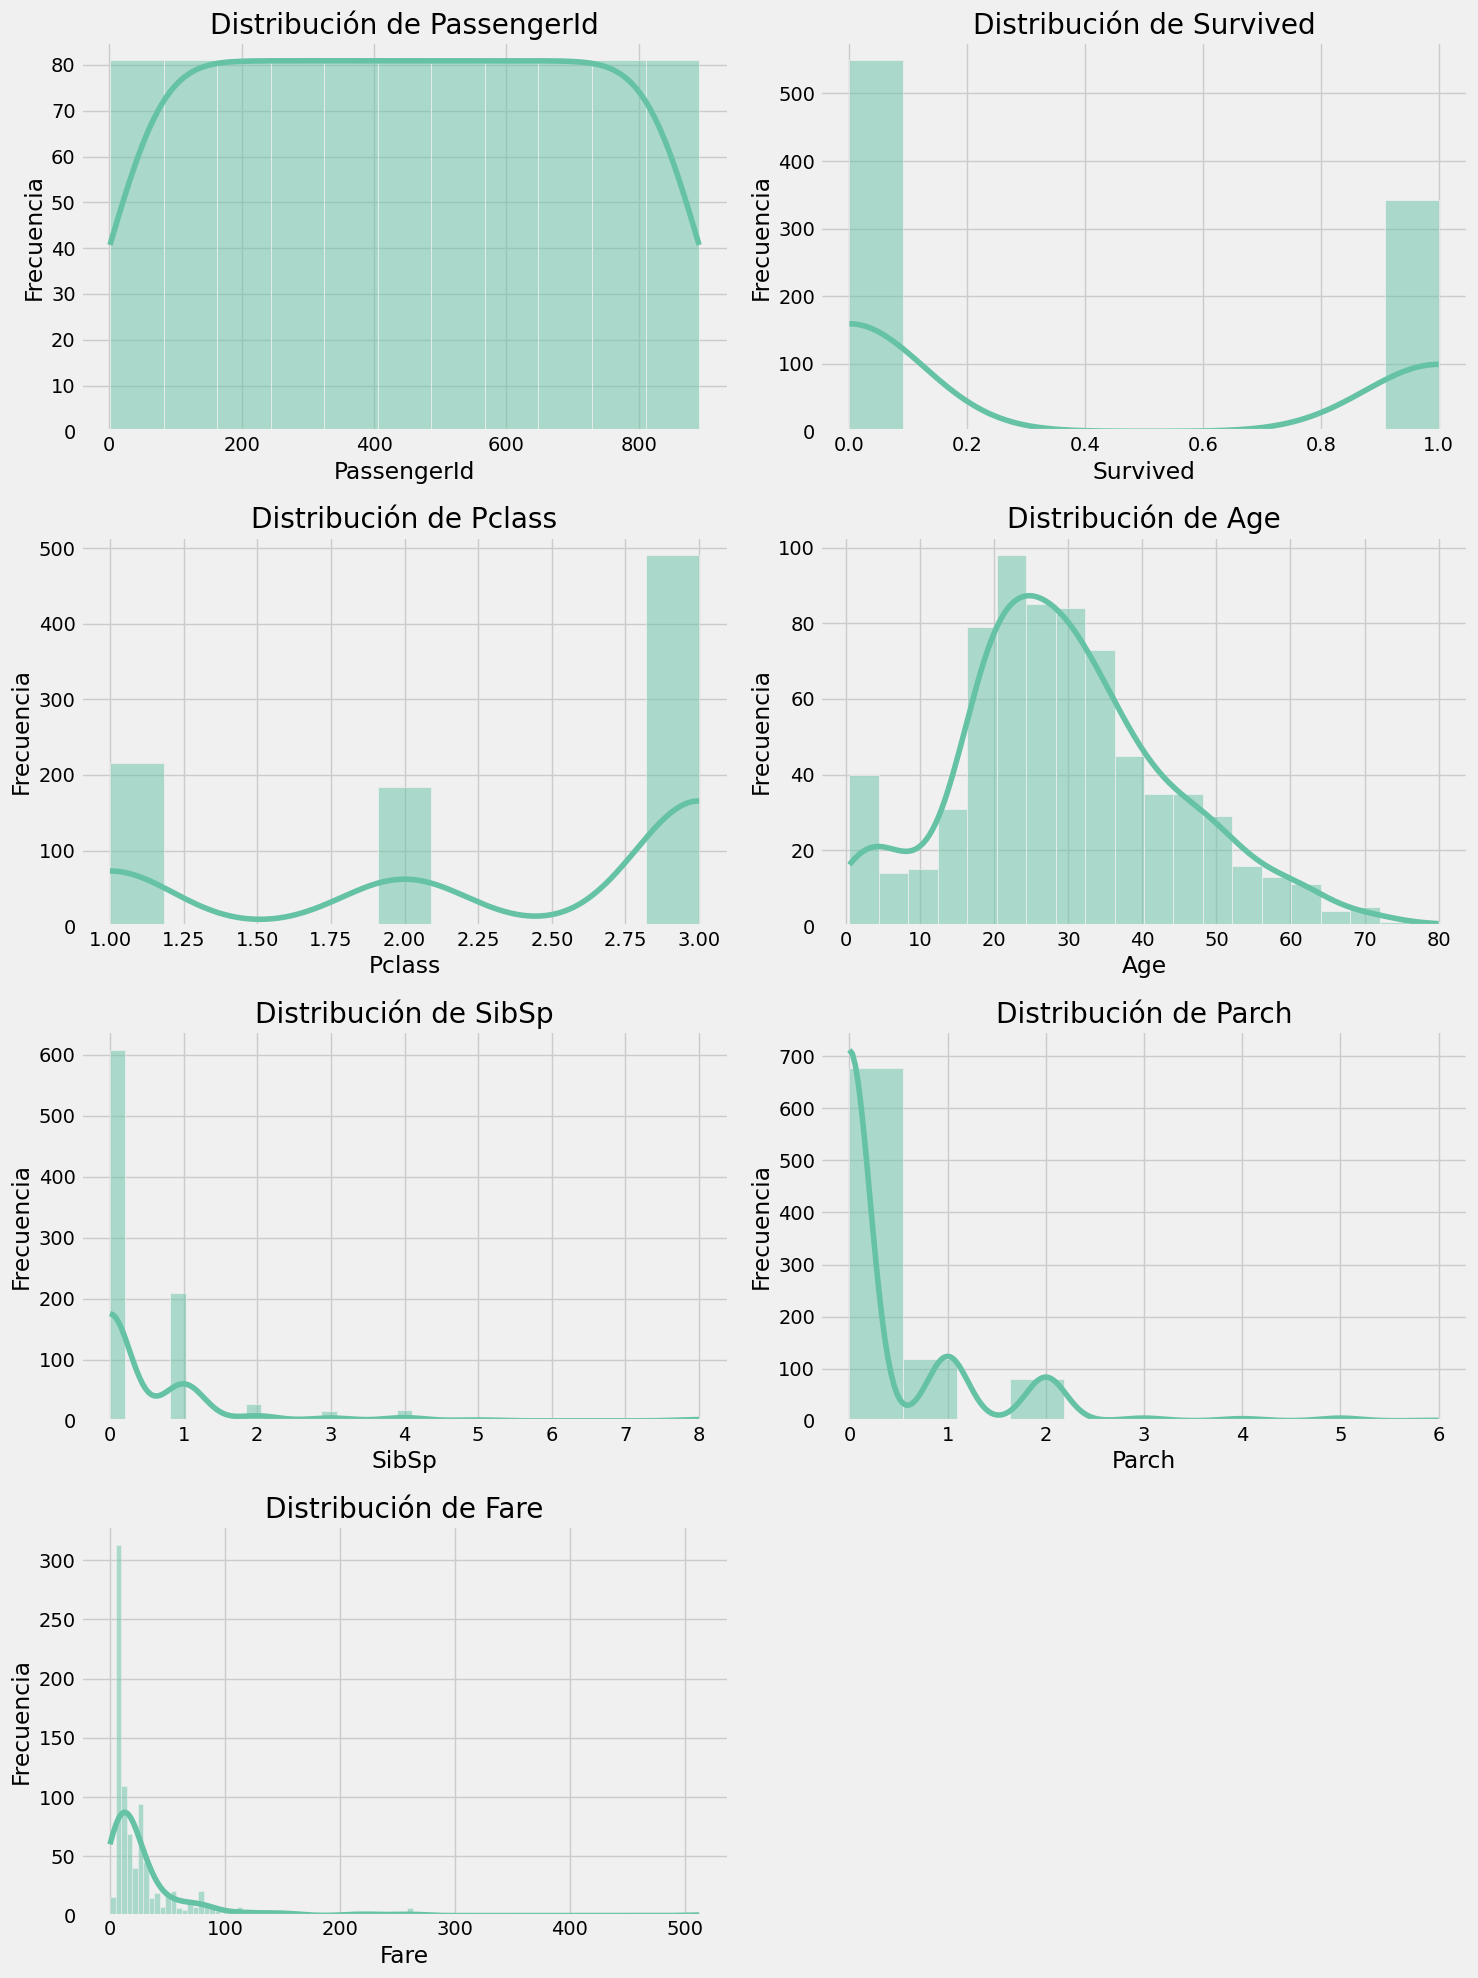

In [13]:
# Visualización de distribuciones numéricas
n_cols = len(numeric_cols)
n_rows = (n_cols + 1) // 2
plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

### 1.1.5 Análisis de Variables Categóricas
Exploramos las variables categóricas para comprender su distribución y la presencia de valores faltantes.

In [14]:
# Análisis de variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
print("3. Análisis de Variables Categóricas:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print(f"Valores únicos: {df[col].nunique()}")
    print(f"Valores faltantes: {df[col].isnull().sum()}")

3. Análisis de Variables Categóricas:

Name:
Name
Dooley, Mr. Patrick                                    1
Braund, Mr. Owen Harris                                1
Cumings, Mrs. John Bradley (Florence Briggs Thayer)    1
Heikkinen, Miss. Laina                                 1
Futrelle, Mrs. Jacques Heath (Lily May Peel)           1
                                                      ..
Hewlett, Mrs. (Mary D Kingcome)                        1
Vestrom, Miss. Hulda Amanda Adolfina                   1
Andersson, Mr. Anders Johan                            1
Saundercock, Mr. William Henry                         1
Bonnell, Miss. Elizabeth                               1
Name: count, Length: 891, dtype: int64
Valores únicos: 891
Valores faltantes: 0

Sex:
Sex
male      577
female    314
Name: count, dtype: int64
Valores únicos: 2
Valores faltantes: 0

Ticket:
Ticket
347082              7
1601                7
CA. 2343            7
3101295             6
CA 2144             6
              

### 1.1.6 Relaciones con la Variable Objetivo (Supervivencia)
Analizamos cómo se relacionan las diferentes variables con la supervivencia para entender qué factores podrían ser importantes para la imputación.

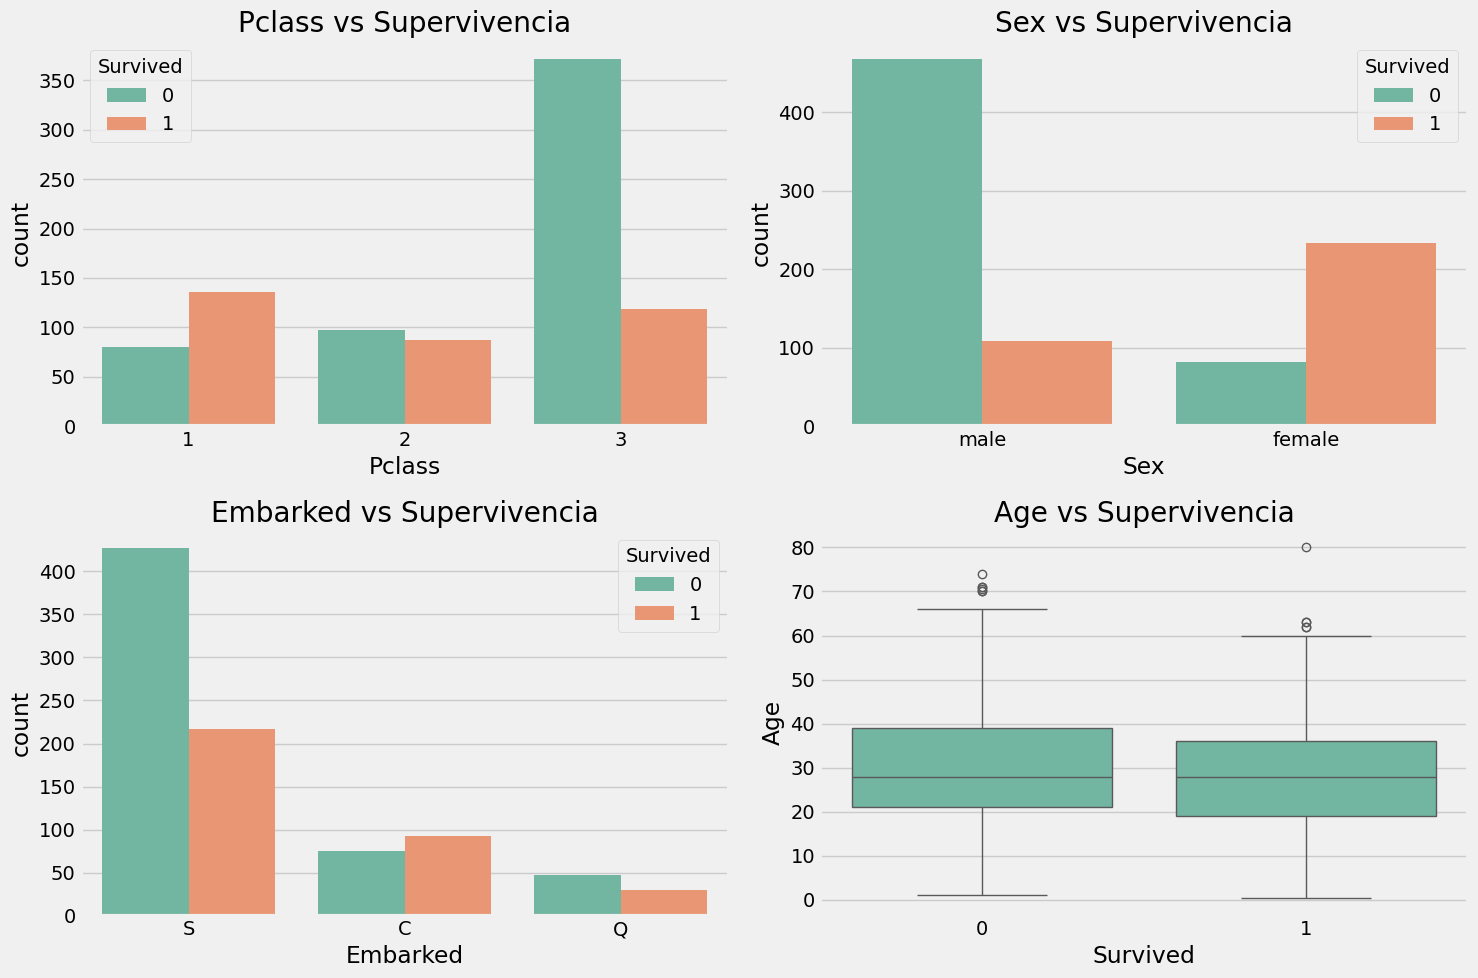

In [15]:
# Visualización de relaciones con la supervivencia
plt.figure(figsize=(15, 10))
for i, col in enumerate(['Pclass', 'Sex', 'Embarked', 'Age'], 1):
    plt.subplot(2, 2, i)
    if col == 'Age':
        sns.boxplot(x='Survived', y=col, data=df)
    else:
        sns.countplot(data=df, x=col, hue='Survived')
    plt.title(f'{col} vs Supervivencia')
plt.tight_layout()
plt.show()

### 1.1.7 Matriz de Correlación
Examinamos las correlaciones entre variables numéricas para identificar relaciones que puedan ser útiles en el proceso de imputación.

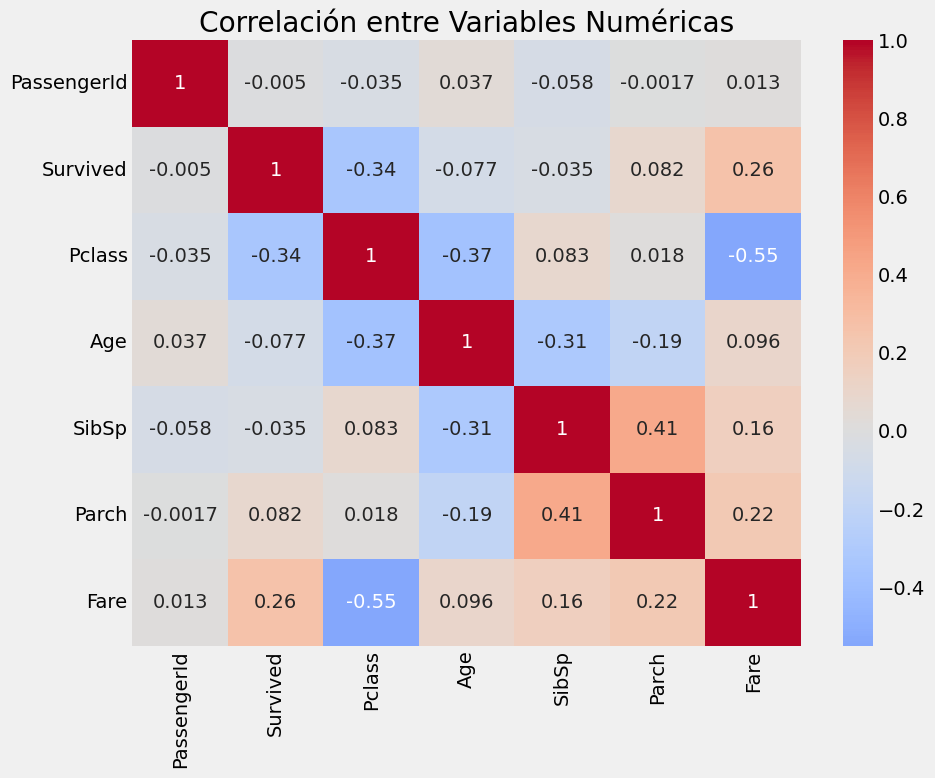

In [16]:
# Matriz de correlación para variables numéricas
plt.figure(figsize=(10, 8))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre Variables Numéricas')
plt.tight_layout()
plt.show()